In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import json
import math
import cv2
import PIL
from PIL import Image
import seaborn as sns
sns.set(style='darkgrid')
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.decomposition import PCA

%matplotlib inline

Using TensorFlow backend.


In [2]:
sub = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')

In [3]:
import os
print(os.listdir("../input/siim-isic-melanoma-classification"))

['tfrecords', 'train.csv', 'train', 'test', 'test.csv', 'sample_submission.csv', 'jpeg']


In [4]:
#Loading Train and Test Data
train = pd.read_csv("../input/siim-isic-melanoma-classification/train.csv")
test = pd.read_csv("../input/siim-isic-melanoma-classification/test.csv")
print("{} images in train set.".format(train.shape[0]))
print("{} images in test set.".format(test.shape[0]))

33126 images in train set.
10982 images in test set.


In [5]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [6]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


Let's look at the distribution of teh target:

In [7]:
np.mean(train.target)

0.01762965646320111

So this is a binary classification problem with highly imbalanced data.

Let's take a look at a few images.

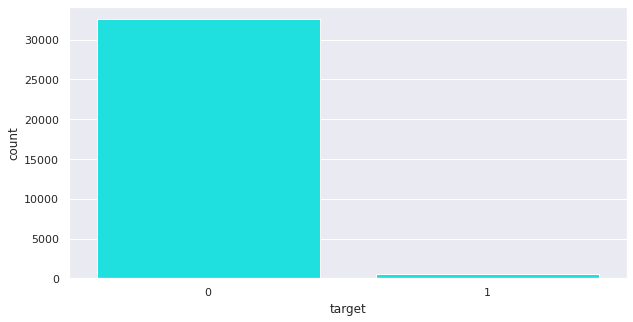

In [8]:
plt.figure(figsize=(10,5))
sns.countplot(x='target', data=train,
                   order=list(train['target'].value_counts().sort_index().index) ,
                   color='cyan')

In [9]:
train['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

In [10]:
train.columns

Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target'],
      dtype='object')

In [11]:
z=train.groupby(['target','sex'])['benign_malignant'].count().to_frame().reset_index()
z.style.background_gradient(cmap='Reds')  

,target,sex,benign_malignant
0,0,female,15761
1,0,male,16716
2,1,female,220
3,1,male,364


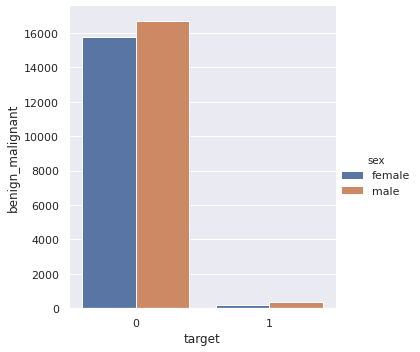

In [12]:
sns.catplot(x='target',y='benign_malignant', hue='sex',data=z,kind='bar')

In [13]:
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Convolution2D,Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.callbacks import TensorBoard
from keras import applications

**TRAINING**

In [14]:
import time 

In [15]:
start=time.time()
train_images = np.load('../input/rgb-3500-96/train_images_rgb_3500_96.npy')
end=time.time()
print(f"\nTime to load train images: {round(end-start,5)} seconds.")
print('Train_images shape: ',train_images.shape)


Time to load train images: 0.36773 seconds.
Train_images shape:  (3874, 96, 96, 3)


In [17]:
start=time.time()
test_images = np.load('../input/test-images-rgb-10000-96/test_images_rbg_10000_96.npy')
end=time.time()
print(f"\nTime to load test images: {round(end-start,5)} seconds.")
print('Test_images shape: ',test_images.shape)


Time to load test images: 1.03321 seconds.
Test_images shape:  (10982, 96, 96, 3)


In [18]:
#target data
train_labels =np.load('../input/rgb-3500-96/train_labels_rgb_3500_96.npy')
print('Train_labels shape: ',train_labels.shape)

Train_labels shape:  (3874,)


In [19]:
#spliting train data
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(train_images,train_labels,test_size=0.3)

In [20]:
print('x_train shape: ',x_train.shape)
print('x_val shape: ',x_val.shape)

x_train shape:  (2711, 96, 96, 3)
x_val shape:  (1163, 96, 96, 3)


**DATA AUGMENTATION**

In [21]:
augs = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

augs.fit(x_train)

**MODELLING**

In [24]:
#VGG-16 MODEL NO. 1
from keras.applications.vgg16 import VGG16

    
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(32,32,3)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 34, 34, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)      

In [25]:
#XCEPTION MODEL NO. 2
from keras.layers import Dropout, DepthwiseConv2D, MaxPooling2D, concatenate
from keras.models import Model

inp = Input(shape = (96,96, 3))
x = inp
x = Conv2D(32, (3, 3), strides = 2, padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x = Conv2D(64, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)

x1 = DepthwiseConv2D((3, 3), (1, 1), padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = DepthwiseConv2D((3, 3), (1, 1), padding = "same", activation = "relu")(x1)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = MaxPooling2D((2, 2), strides = 1)(x1)

x = concatenate([x1, Conv2D(64, (2, 2), strides = 1)(x)])

x1 = Activation("relu")(x)
x1 = Conv2D(256, (3, 3), strides = 1, padding = "same", activation = "relu")(x1)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = DepthwiseConv2D((3, 3), strides = 1, padding = "same", activation = "relu")(x1)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = DepthwiseConv2D((3, 3), strides = 1, padding = "same")(x1)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = MaxPooling2D((2, 2), strides = 1)(x1)

x = concatenate([x1, Conv2D(256, (2, 2), strides = 1)(x)])


x = Activation("relu")(x)
x = Conv2D(256, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x = Conv2D(128, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x = Flatten()(x)

x = Dense(1, activation = "sigmoid")(x)


model2 = Model(inp, x)
model2.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 48, 48, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 48, 48, 32)   128         conv2d_14[0][0]                  
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 48, 48, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [28]:
#DENSENET MODEL NO. 3
from tensorflow.keras.applications import DenseNet201
import tensorflow.keras.layers as L
dnet201 = DenseNet201(
    input_shape=(96,96, 3),
    include_top=False
)
dnet201.trainable = True

model3 = tf.keras.Sequential([
    dnet201,
    L.GlobalAveragePooling2D(),
    L.Dense(1, activation='sigmoid')
])
model3.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

model3.summary()

KeyboardInterrupt: 

In [ ]:
batch_size=128
epochs=30

history = model.fit(x_train,
             y_train,
             batch_size=batch_size,
             nb_epoch=epochs,
             verbose=1,
             validation_data=(x_val,y_val))

In [ ]:
batch_size=128
epochs=15

history2 = model2.fit(x_train,
             y_train,
             batch_size=batch_size,
             nb_epoch=epochs,
             verbose=1,
             validation_data=(x_val,y_val))

In [ ]:
batch_size=128
epochs=30

history3 = model3.fit(x_train,
             y_train, 
             batch_size=batch_size,
             nb_epoch=epochs,
             verbose=1,
             validation_data=(x_val,y_val))

In [ ]:
model.save("vgg16.h5")

In [ ]:
model2.save("xception.h5")

In [ ]:
model3.save("densenet.h5") 

**EVALUATION**

In [ ]:
scores = model.evaluate(x_val, y_val, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
scores = model2.evaluate(x_val, y_val, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
scores = model3.evaluate(x_val, y_val, verbose=0)
print('Test loss_3:', scores[0])
print('Test accuracy_3:', scores[1])

**PREDICTION**

In [ ]:
y_test_prob = model.predict(test_images)
pred_df = pd.DataFrame({'image_name': test['image_name'], 'target': np.concatenate(y_test_prob)})
pred_df.to_csv('submission_vgg.csv',header=True, index=False)
pred_df.head(10)

In [ ]:
y_test_prob2 = model2.predict(test_images)
pred_df2 = pd.DataFrame({'image_name': test['image_name'], 'target': np.concatenate(y_test_prob2)})
pred_df2.to_csv('submission_xception.csv',header=True, index=False)
pred_df2.head(10)

In [ ]:
y_test_prob3 = model3.predict(test_images)
pred_df3 = pd.DataFrame({'image_name': test['image_name'], 'target': np.concatenate(y_test_prob3)})
pred_df3.to_csv('submission_dense.csv',header=True, index=False)
pred_df3.head(10)

**ENSEMBLE**

In [ ]:
en = pd.DataFrame({'image_name':test['image_name'], 'target':(0.3*pred_df['target'] + 0.3*pred_df2['target'] + 0.3*pred_df3['target'])})
en.to_csv('ensemble1.csv',header=True, index=False)
en.head(10)